In [83]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [84]:
SEED = 42
NUM_EPOCHS = 30
TARGET_LABEL = "dx"
BALANCE_LABEL = "dx"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

In [85]:
FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path

In [86]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

In [87]:
# Setting up the Image Data Generators
#Dadurch wird die Augmentation während des Trainings on-the-fly durchgeführt.
datagen_train = ImageDataGenerator(
    rescale=1.0 / 255.0,
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_validation = ImageDataGenerator(
    rescale=1.0 / 255.0, #see above
    preprocessing_function=preprocess_input
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

train_data_generator = datagen_train.flow_from_dataframe(
        dataframe=train_df,
        directory=FILEPATH_JPGS,
        x_col="image_id",
        y_col=TARGET_LABEL,
        class_mode="categorical",
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE
)

Found 2003 validated image filenames belonging to 7 classes.


Found 5256 validated image filenames belonging to 7 classes.


In [88]:
# EarlyStopping-Callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metrik, die überwacht wird
    patience=10,         # Anzahl der Epochen ohne Verbesserung
    verbose=1,           # Ausgabe-Steuerung
    restore_best_weights=True  # Die besten Gewichtungen wiederherstellen
)

In [89]:
# ReduceLROnPlateau-Callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metrik, die überwacht wird
    factor=0.1,          # Faktor, um die Lernrate zu reduzieren
    patience=5,          # Anzahl der Epochen ohne Verbesserung
    verbose=1,           # Ausgabe-Steuerung
    min_lr=1e-6          # Minimale Lernrate
)

**Build Model:**

In [90]:
# Initialize the MobileNetV3Large model
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze the base model's layers to use it for feature extraction
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = layers.Conv2D(128, (3, 3), activation='relu')(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(7, activation='softmax')(x)


# Create the full model
model = Model(inputs=base_model.input, outputs=x, name="MobilneNetV3Large_pretrained-weights_fixed-layers_custom-conv2D")


In [91]:
# Compile the model
# Ältere Version des Adam-Optimierers für M1/M2 Macs
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# model.summary()

In [92]:
# Train the model

history = model.fit(
    train_data_generator,
    epochs=NUM_EPOCHS,
    verbose=1,                      # Adjust verbosity level
    batch_size=BATCH_SIZE,                # Set the batch size, default is 32, can be increased to speed up training, but memory consumption increases
    callbacks=[early_stopping, reduce_lr],                 # List of callbacks to apply during training
    validation_split=0.0,           # not needed as we use a validation data generator
    validation_data=validation_generator,
    shuffle=True,                   # Shuffle the training data before each epoch
    sample_weight=None,             # Set the weights for the train data set !
    class_weight=None,              # Set the weights for the classes, not needed if we use sample weights
    initial_epoch=0,                # Use this to continue training from a specific epoch
    steps_per_epoch=None,           # Set the number of steps per epoch, default is len(x_train) // batch_size
    validation_steps=None,          # Set the number of steps for validation, default is len(x_val) // batch_size
    validation_batch_size=None,     # Set the batch size for validation, default is batch_size
    validation_freq=1,              # Only relevant if validation data is a generator. Set the frequency to validate the model on the validation set
    max_queue_size=10,              # Set the max size for the generator queue
    workers=-1,                     # Set the max number of processes to generate the data in parallel, -1 means all CPUs
    use_multiprocessing=False       # Set to True if you use a generator in parallel, e.g. model.predict_generator()
)

Epoch 1/30
83/83 [==============================] - 69s 806ms/step - loss: 2.4769 - accuracy: 0.1701 - val_loss: 2.1608 - val_accuracy: 0.6695 - lr: 0.0010
Epoch 2/30
83/83 [==============================] - 68s 822ms/step - loss: 2.1610 - accuracy: 0.1819 - val_loss: 1.7303 - val_accuracy: 0.1098 - lr: 0.0010
Epoch 3/30
83/83 [==============================] - 72s 871ms/step - loss: 2.0026 - accuracy: 0.1973 - val_loss: 1.9275 - val_accuracy: 0.0539 - lr: 0.0010
Epoch 4/30
83/83 [==============================] - 73s 879ms/step - loss: 1.9281 - accuracy: 0.2199 - val_loss: 1.6824 - val_accuracy: 0.5457 - lr: 0.0010
Epoch 5/30
83/83 [==============================] - 73s 874ms/step - loss: 1.8844 - accuracy: 0.2275 - val_loss: 1.8906 - val_accuracy: 0.0315 - lr: 0.0010
Epoch 6/30
83/83 [==============================] - 73s 881ms/step - loss: 1.8580 - accuracy: 0.2298 - val_loss: 1.7300 - val_accuracy: 0.2801 - lr: 0.0010
Epoch 7/30
83/83 [==============================] - 74s 891ms/st

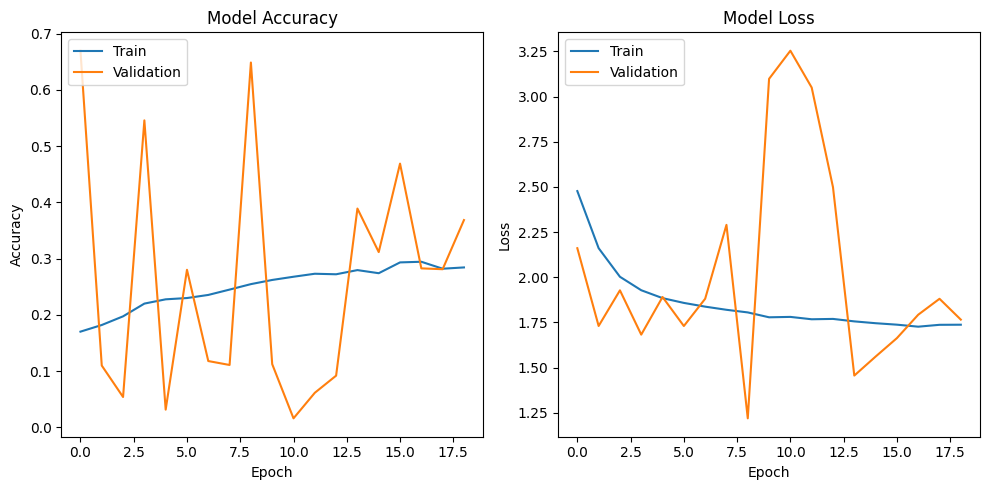

In [93]:
import matplotlib.pyplot as plt

# 'history' ist das Objekt, das von model.fit zurückgegeben wird
# Es enthält den Trainingsverlauf zum plotten

# accuracy plotten
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Verlust plotten
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [94]:
""" from datetime import datetime
timestamp = datetime.now()
model_path = f"{FILEPATH_OUTPUT}model_colab_{timestamp}.h5"
model.save(model_path) """



' from datetime import datetime\ntimestamp = datetime.now()\nmodel_path = f"{FILEPATH_OUTPUT}model_colab_{timestamp}.h5"\nmodel.save(model_path) '